<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br>
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>
<br>
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>
<br>
<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>

<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>




Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [1]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd

# Enter data folder location
loc = "./MEx"

In [2]:
# Find, read, and compose the measurements
from utilities.fun_one import path_to_meta
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)

    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df

    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...
1,03,04,2,act,acc,time acc_0 acc_1 acc_2 0 ...
2,03,06,1,act,acc,time acc_0 acc_1 acc_2 0 ...
3,03,04,1,act,acc,time acc_0 acc_1 acc_2 0 ...
4,03,03,1,act,acc,time acc_0 acc_1 acc_2 0 ...


Dataframe with one measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


In [3]:
# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.

for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())

    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue

        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()

        records_windowed.append(tmp_data)

df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())
%store df_records_windowed

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,03,02,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,03,02,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,03,02,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,03,02,1,act,acc,time acc_0 acc_1 acc_2 80...,4


Dataframe with one windowed measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


Stored 'df_records_windowed' (DataFrame)


## 1.1. Visualize selected samples for both modalities

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import importlib, utilities
importlib.reload(utilities)
from utilities.fun_one import visualize, visualize_acceleration, visualize_depth, visualize_depth_series

Acceleration, Person 1, Exercise 2:


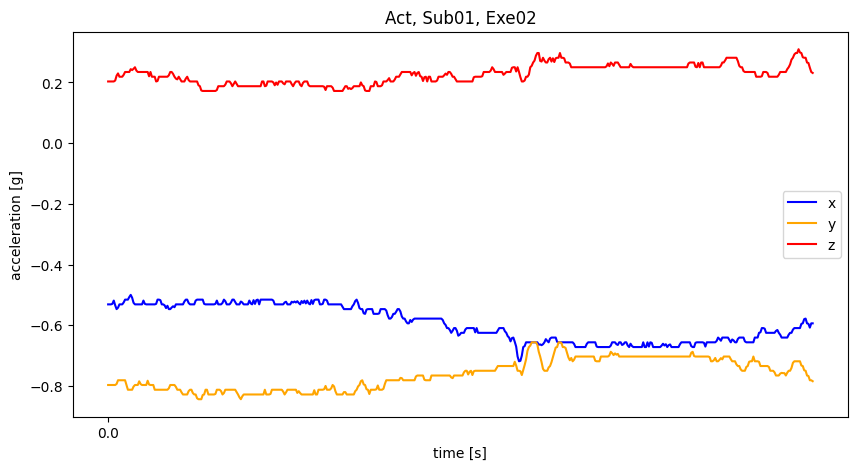

Acceleration, Person 1, Exercise 5:


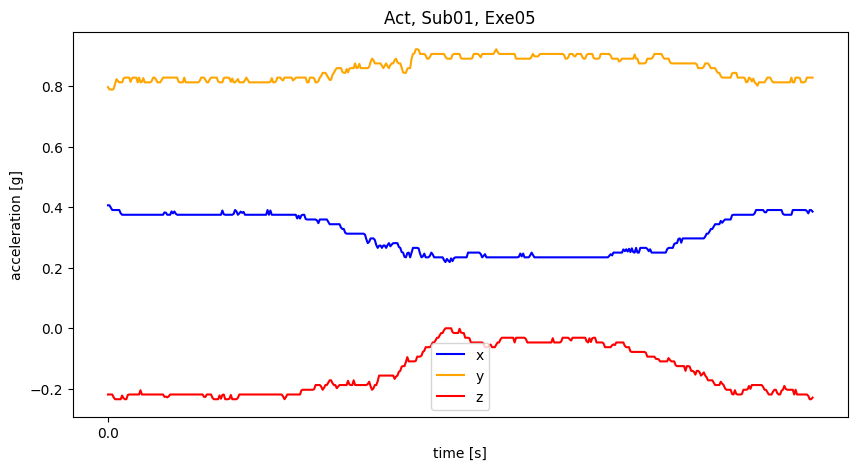

Acceleration, Person 1, Exercise 6:


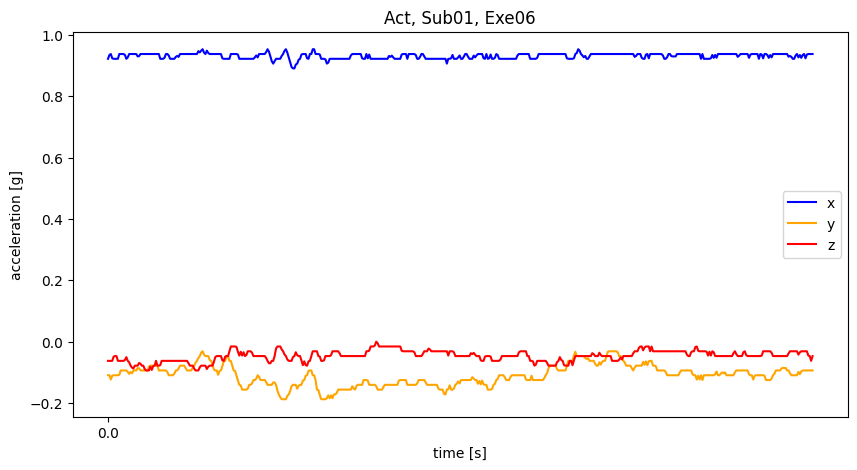

Acceleration, Person 5, Exercise 2:


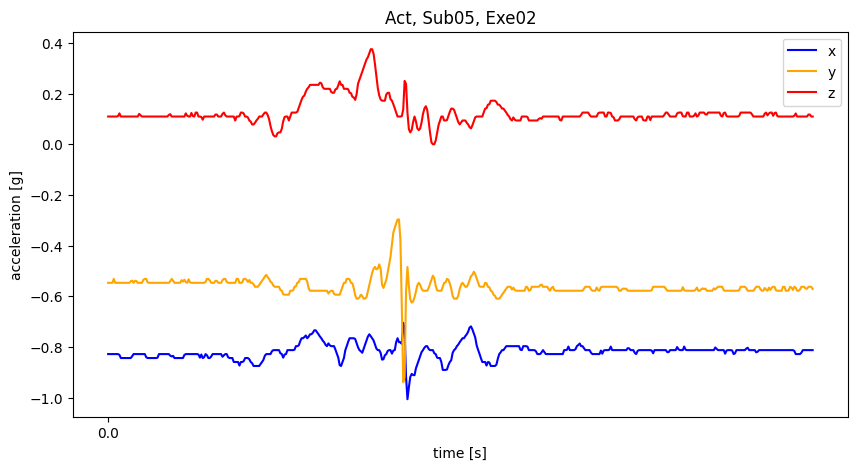

Acceleration, Person 5, Exercise 5:


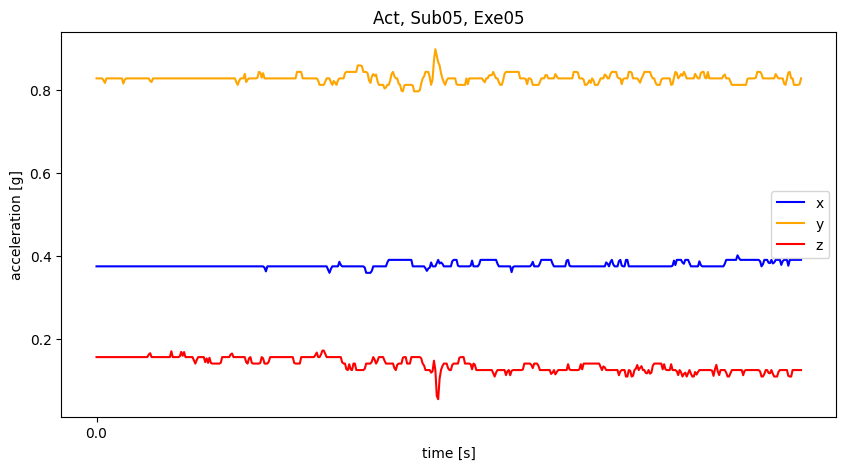

Acceleration, Person 5, Exercise 6:


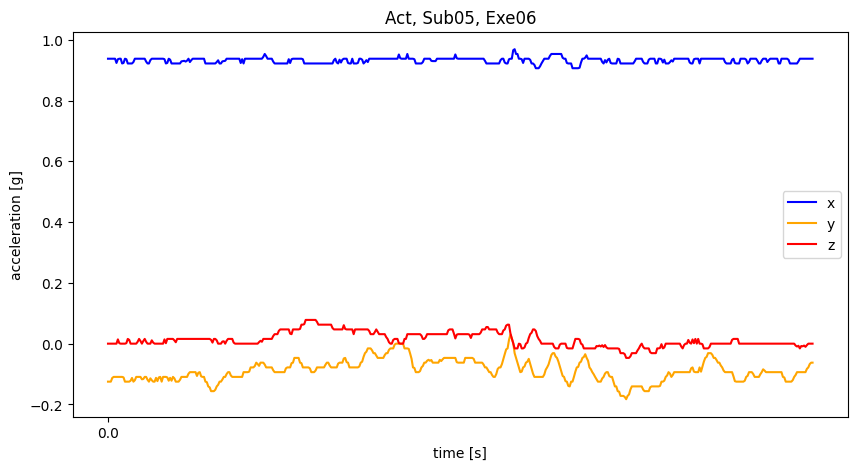

In [5]:
# Visualisation - Acceleration:
%matplotlib inline
print("Acceleration, Person 1, Exercise 2:")
visualize_acceleration(df_records_windowed,1,2)
print("Acceleration, Person 1, Exercise 5:")
visualize_acceleration(df_records_windowed,1,5)
print("Acceleration, Person 1, Exercise 6:")
visualize_acceleration(df_records_windowed,1,6)
print("Acceleration, Person 5, Exercise 2:")
visualize_acceleration(df_records_windowed,5,2)
print("Acceleration, Person 5, Exercise 5:")
visualize_acceleration(df_records_windowed,5,5)
print("Acceleration, Person 5, Exercise 6:")
visualize_acceleration(df_records_windowed,5,6)

### Review of Accelerometer data visualisation
The accelerometer data is presented as a series of charts each representing one subject doing one exercise. Plots present readings of 3D accelerometer over first time window (window index can be changed by the parameter of visualization function) of 5 seconds. We see that same exercises (e.g. Exe6) have similar characteristics (both have 1g acceleration over axis x, and almost 0 over other axes. Other exercises have different average distribution of acceleration over other axes).

On the other hand Person 5, Exercise 2 has big bump over all axes, which is not present in the sample Person 1, Exercise 2. This may refer to some noise of the data. Maybe the sensor was hit by something.

Visualisation Depth Series, First Window:
Person 1, Exercise 2:


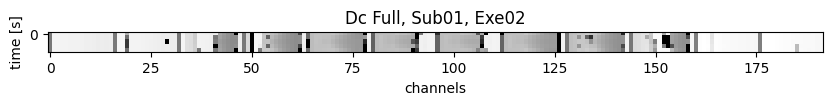

Person 1, Exercise 5:


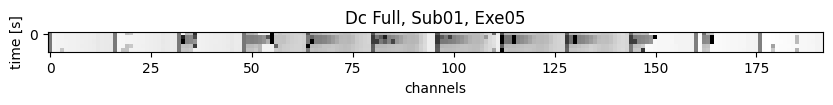

Person 1, Exercise 6:


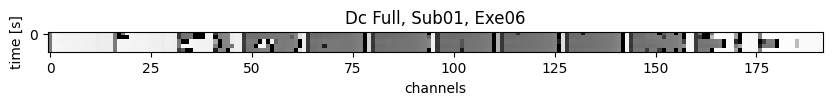

Person 5, Exercise 2:


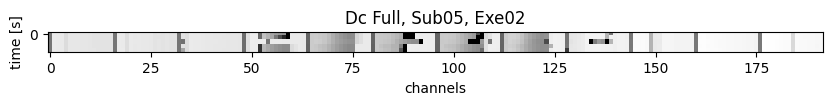

Person 5, Exercise 5:


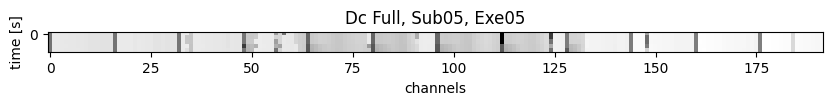

Person 5, Exercise 6:


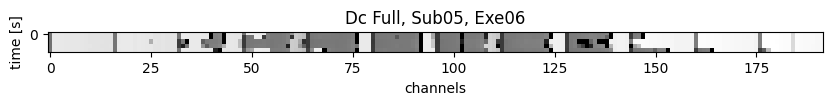

In [6]:
# Visualisation - Depth:
%matplotlib inline
print("Visualisation Depth Series, First Window:")
print("Person 1, Exercise 2:")
visualize_depth_series(df_records_windowed,1,2)
print("Person 1, Exercise 5:")
visualize_depth_series(df_records_windowed,1,5)
print("Person 1, Exercise 6:")
visualize_depth_series(df_records_windowed,1,6)
print("Person 5, Exercise 2:")
visualize_depth_series(df_records_windowed,5,2)
print("Person 5, Exercise 5:")
visualize_depth_series(df_records_windowed,5,5)
print("Person 5, Exercise 6:")
visualize_depth_series(df_records_windowed,5,6)

## Review of the Depth sensor time series data visualization
In the first part of visualization, we see channels arranged in a row, stacked over time series. The first thing to notice, that some channels (at the edges of the frame) have little variance, and they may not carry too much information. So the dimensionality reduction would be helpful

In [23]:
print("Person 1, Exercise 2:")
%matplotlib notebook
visualize_depth(df_records_windowed,1,2,None)

Person 1, Exercise 2:


<IPython.core.display.Javascript object>

In [24]:
print("Person 1, Exercise 5:")
%matplotlib notebook
visualize_depth(df_records_windowed,1,5,None)

Person 1, Exercise 5:


<IPython.core.display.Javascript object>

In [25]:
print("Person 1, Exercise 6:")
%matplotlib notebook
visualize_depth(df_records_windowed,1,6,None)

Person 1, Exercise 6:


<IPython.core.display.Javascript object>

In [26]:
print("Person 5, Exercise 2:")
%matplotlib notebook
visualize_depth(df_records_windowed,5,2,None)

Person 5, Exercise 2:


<IPython.core.display.Javascript object>

In [27]:
print("Person 5, Exercise 5:")
%matplotlib notebook
visualize_depth(df_records_windowed,5,5,None)

Person 5, Exercise 5:


<IPython.core.display.Javascript object>

In [28]:
print("Person 5, Exercise 6:")
%matplotlib notebook
visualize_depth(df_records_windowed,5,6,None)

Person 5, Exercise 6:


<IPython.core.display.Javascript object>

In [29]:
print("Person 5, Exercise 6:")
%matplotlib notebook
visualize_depth(df_records_windowed,5,6,None)

Person 5, Exercise 6:


<IPython.core.display.Javascript object>

## Review of the Depth sensor data visualization as animated images
Depth sensor data are presented as an animated sequence of images. There we can see not only the rough shape of test subject and his movements. Edges of the frame show no variance, as the subject is placed in the centre of the image. On the other hand, some pixels switch from 0 to 1 over time of one step in animation. This may indicate some false reading of the sensor.

## 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

In [14]:
%matplotlib inline
import importlib
importlib.reload(utilities.fun_one)
from utilities.fun_one import stringify_id
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments
print("Splitting data into train ( persons 1-7 ) and test set (persons 8-10)")

#Create training and testing set by combining chosen subject data:
training_records = df_records_windowed[(df_records_windowed.subject_id == stringify_id(1)) |
                                       (df_records_windowed.subject_id == stringify_id(2)) |
                                       (df_records_windowed.subject_id == stringify_id(3)) |
                                       (df_records_windowed.subject_id == stringify_id(4)) |
                                       (df_records_windowed.subject_id == stringify_id(5)) |
                                       (df_records_windowed.subject_id == stringify_id(6)) |
                                       (df_records_windowed.subject_id == stringify_id(7))]
testing_records = df_records_windowed[(df_records_windowed.subject_id == stringify_id(8)) |
                                      (df_records_windowed.subject_id == stringify_id(9)) |
                                      (df_records_windowed.subject_id == stringify_id(10))]

# Drop one row from training set which does not have a pair of sensor readings:
training_records = training_records.drop(training_records.index[(training_records.subject_id == stringify_id(2)) &
                                                                (training_records.exercise_id == stringify_id(6)) &
                                                                (training_records.sensor_code == 'act') &
                                                                (training_records.window_idx == 29)])


#Save for use in other notebooks:
%store training_records
%store testing_records

Splitting data into train ( persons 1-7 ) and test set (persons 8-10)
Stored 'training_records' (DataFrame)
Stored 'testing_records' (DataFrame)


In [15]:
training_records

,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,03,02,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,03,02,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,03,02,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,03,02,1,act,acc,time acc_0 acc_1 acc_2 80...,4
...,...,...,...,...,...,...,...
4164,06,02,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,31
4165,06,02,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,32
4166,06,02,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,33
4167,06,02,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,34


In [16]:
testing_records

,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
822,10,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
823,10,02,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
824,10,02,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
825,10,02,1,act,acc,time acc_0 acc_1 acc_2 60...,3
826,10,02,1,act,acc,time acc_0 acc_1 acc_2 80...,4
...,...,...,...,...,...,...,...
3732,08,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,16
3733,08,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,17
3734,08,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,18
3735,08,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,19


# Dataframe description

Overall length of datasets are **2972 samples in Train dataset** and **1196 samples in Test dataset**. This is because each time window is doubled for each modality (Depth sensor and Accelerometer) readings.

In [17]:
print('Overall length of training set: ', len(training_records))
print('Overall length of testing set: ', len(testing_records))

Overall length of training set:  2972
Overall length of testing set:  1196


Lenghts of train and  test dataset for each modality (Depth sensor and Accelerometer) are then **598 samples in Train dataset** and **598 samples in Test dataset**

In [18]:
print('Length of accelerometer training set: ', len(training_records[training_records.sensor == 'acc']))
print('Length of accelerometer testing set: ', len(testing_records[testing_records.sensor == 'acc']))
print('Length of depth sensor training set: ', len(training_records[training_records.sensor == 'dc']))
print('Length of depth sensor training set: ', len(testing_records[testing_records.sensor == 'dc']))

Length of accelerometer training set:  1486
Length of accelerometer testing set:  598
Length of depth sensor training set:  1486
Length of depth sensor training set:  598


Shape of the dataset is then number_of_samples*7. 7 refers to the columns of the dataset. At this point they don't represent the features of measured data, but rather metadata of each measurement. As in the display above, they hold **metadata** information like subject and sensor with which the sample of certain exercise was recorded.

In [19]:
print('Shape of train dataset: ', training_records.shape)
print('Shape of test dataset: ', testing_records.shape)

Shape of train dataset:  (2972, 7)
Shape of test dataset:  (1196, 7)


### Actual measurements data

The values of measurement's are held in the column 'df' containing data frames of each windowed recording. The properties of the dataframes vary among the sensor type (Accelerometer or Depth sensor) used to record the data.

In [20]:
print('Shape of accelerometer recording window with data values: ', training_records[training_records.sensor == 'acc'].iloc[0]['df'].shape)
print('Shape of depth sensor recording window with data values: ', training_records[training_records.sensor == 'dc'].iloc[0]['df'].shape)

Shape of accelerometer recording window with data values:  (500, 4)
Shape of depth sensor recording window with data values:  (5, 193)


## Accelerometer data

Accelerometer data consist of readings of 3 accelerometer axis. Fist column represents time series and other 3 accelerometer axis. Values in the of the first sample range from -0.8 to 0.85, sou roughly from -1 to 1.

In [21]:
display(training_records[training_records.sensor == 'acc'].iloc[0]['df'])
print("Minimal value of dataframe: ", np.min(training_records[training_records.sensor == 'acc'].iloc[0]['df'].values[:,1:]))
print("Maximal value of dataframe: ", np.max(training_records[training_records.sensor == 'acc'].iloc[0]['df'].values[:,1:]))

,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312
...,...,...,...,...
495,4950.0,-0.500000,0.796875,-0.234375
496,4960.0,-0.500000,0.796875,-0.234375
497,4970.0,-0.500000,0.812500,-0.234375
498,4980.0,-0.500000,0.796875,-0.234375


Minimal value of dataframe:  -0.796875
Maximal value of dataframe:  0.857812


## Depth sensor data

The shape of data indicates that one window consists of 5 images with 192 features (pixels). There is also one more feature, for time label. Values in the of the first sample range from 0 to 0.96, so roughly from 0 to 1.

In [22]:
display(training_records[training_records.sensor == 'dc'].iloc[0]['df'])
print("Minimal value of dataframe: ", np.min(training_records[training_records.sensor == 'dc'].iloc[0]['df'].values[:,1:]))
print("Maximal value of dataframe: ", np.max(training_records[training_records.sensor == 'dc'].iloc[0]['df'].values[:,1:]))

,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,...,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
0,0.0,0.4589,0.9178,0.9257,0.921,0.921,0.9178,0.9149,0.9139,0.9116,...,0.9578,0.9531,0.9531,0.9531,0.9499,0.9499,0.9468,0.9468,0.9397,0.9397
1,1000.0,0.4605,0.9194,0.9249,0.921,0.921,0.9178,0.9139,0.9133,0.9122,...,0.9578,0.9531,0.9531,0.9531,0.9499,0.9499,0.9468,0.9468,0.9397,0.9397
2,2000.0,0.4605,0.9178,0.9249,0.921,0.921,0.9178,0.9139,0.9133,0.9116,...,0.9570,0.9531,0.9531,0.9531,0.9499,0.9499,0.9468,0.9468,0.9397,0.9397
3,3000.0,0.4589,0.9176,0.9241,0.921,0.921,0.9178,0.9139,0.9139,0.9116,...,0.9586,0.9531,0.9531,0.9531,0.9499,0.9499,0.9468,0.9468,0.9397,0.9397
4,4000.0,0.4605,0.9186,0.9249,0.921,0.921,0.9178,0.9139,0.9122,0.9122,...,0.9586,0.9531,0.9531,0.9531,0.9499,0.9499,0.9468,0.9468,0.9397,0.9397


Minimal value of dataframe:  0.0
Maximal value of dataframe:  0.9671
